# **Decision Tree with own imputation**

**The needed data to be imputed has been imputed here instead of using the obtained in the gold data. In this way, there is a comparison of different imputations.**

In [1]:
# Decision Tree Model with Imputation for Missing Values and Encoding for Categorical Data

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.multioutput import MultiOutputClassifier
from sklearn.impute import SimpleImputer

In [2]:
# Load the datasets
X_train_df = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')
training_set_labels_df = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')
X_test_df = pd.read_csv('data/test_set_features.csv', index_col='respondent_id')



In [3]:
# Check Missing Values
missing_percentages = X_train_df.isnull().mean()
print("Missing percentages in training set:")
print(missing_percentages[missing_percentages > 0])

Missing percentages in training set:
h1n1_concern                   0.003445
h1n1_knowledge                 0.004343
behavioral_antiviral_meds      0.002658
behavioral_avoidance           0.007788
behavioral_face_mask           0.000711
behavioral_wash_hands          0.001573
behavioral_large_gatherings    0.003258
behavioral_outside_home        0.003070
behavioral_touch_face          0.004793
doctor_recc_h1n1               0.080878
doctor_recc_seasonal           0.080878
chronic_med_condition          0.036358
child_under_6_months           0.030704
health_worker                  0.030104
health_insurance               0.459580
opinion_h1n1_vacc_effective    0.014640
opinion_h1n1_risk              0.014528
opinion_h1n1_sick_from_vacc    0.014790
opinion_seas_vacc_effective    0.017299
opinion_seas_risk              0.019246
opinion_seas_sick_from_vacc    0.020107
education                      0.052683
income_poverty                 0.165612
marital_status                 0.052720
ren

In [4]:
# Separate numeric and categorical columns
numeric_columns = X_train_df.select_dtypes(include=['number']).columns
categorical_columns = X_train_df.select_dtypes(include=['object']).columns

In [5]:
# Imputation for Numeric Data
imputer = SimpleImputer(strategy='mean')  # Using mean imputation
X_train_numeric = pd.DataFrame(imputer.fit_transform(X_train_df[numeric_columns]), columns=numeric_columns, index=X_train_df.index)
X_test_numeric = pd.DataFrame(imputer.transform(X_test_df[numeric_columns]), columns=numeric_columns, index=X_test_df.index)


In [6]:
# One-Hot Encoding for Categorical Data
X_train_categorical = pd.get_dummies(X_train_df[categorical_columns], drop_first=True)
X_test_categorical = pd.get_dummies(X_test_df[categorical_columns], drop_first=True)

In [7]:
# Align the columns of training and test categorical data
X_test_categorical = X_test_categorical.reindex(columns=X_train_categorical.columns, fill_value=0)


In [8]:
# Combine numeric and encoded categorical data
X_train_df = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_test_df = pd.concat([X_test_numeric, X_test_categorical], axis=1)

In [9]:
# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_train_df, training_set_labels_df, test_size=0.2, random_state=42, stratify=training_set_labels_df
)

In [10]:
# Hyperparameter Grid for Decision Trees
param_grid = {
    'estimator__max_depth': [3, 5, 10, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}


In [11]:
# MultiOutputClassifier with Decision Tree
multi_output_clf = MultiOutputClassifier(DecisionTreeClassifier(random_state=42))


In [12]:
# GridSearchCV for Hyperparameter Tuning
grid_search = GridSearchCV(
    estimator=multi_output_clf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # Use ROC AUC as the scoring metric
    n_jobs=-1  # Use all available cores
)

In [13]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [3, 5, 10, None],
                         'estimator__min_samples_leaf': [1, 2, 4],
                         'estimator__min_samples_split': [2, 5, 10]},
             scoring='roc_auc')

In [14]:
# Print Best Parameters and Score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (AUC):", grid_search.best_score_)

Best parameters: {'estimator__max_depth': 5, 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 2}
Best cross-validation score (AUC): 0.8308493281790958


In [15]:
# Best Estimator for Predictions
best_estimator = grid_search.best_estimator_
preds = best_estimator.predict_proba(X_test)

In [16]:
# Convert Predictions to DataFrame
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:, 1],
        'seasonal_vaccine': preds[1][:, 1],
    },
    index=y_test.index
)
print('y_preds.shape:', y_preds.shape)

y_preds.shape: (5342, 2)


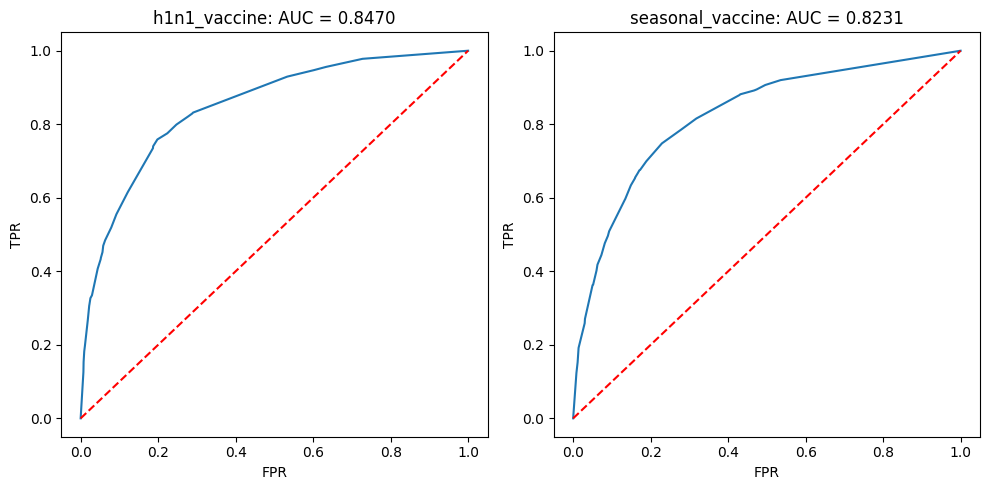

In [17]:
# ROC Curve Plotting
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='red', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plot_roc(
    y_test['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0]
)

plot_roc(
    y_test['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1]
)

fig.tight_layout()


In [18]:
# Final Model Fitting on Full Training Data
best_estimator.fit(X_train_df, training_set_labels_df)
preds = best_estimator.predict_proba(X_test_df)

In [19]:
# Generate Final Predictions
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:, 1],
        'seasonal_vaccine': preds[1][:, 1],
    },
    index=X_test_df.index
)
print('y_preds.shape:', y_preds.shape)

y_preds.shape: (26708, 2)


In [20]:
# Save Predictions to CSV
y_preds.to_csv('results/pred_decision_tree_impute_output.csv', index=True)
